# Network inference of categorical variables: non-sequential data

In [1]:
import sys
import numpy as np
from scipy import linalg
from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt
%matplotlib inline

import inference
import fem

In [2]:
# setting parameter:
np.random.seed(1)

n = 40 # number of positions
m = 3 # number of values at each position
l = int(4*((n*m)**2)) # number of samples
g = 2.

nm = n*m

In [3]:
def itab(n,m):    
    i1 = np.zeros(n)
    i2 = np.zeros(n)
    for i in range(n):
        i1[i] = i*m
        i2[i] = (i+1)*m

    return i1.astype(int),i2.astype(int)

In [4]:
# generate coupling matrix w0:
def generate_interactions(n,m,g):
    nm = n*m
    w = np.random.normal(0.0,g/np.sqrt(nm),size=(nm,nm))
    i1tab,i2tab = itab(n,m)

    for i in range(n):        
        i1,i2 = i1tab[i],i2tab[i]              
        w[i1:i2,:] -= w[i1:i2,:].mean(axis=0)            

    for i in range(n):
        i1,i2 = i1tab[i],i2tab[i]
        w[i1:i2,i1:i2] = 0.   # no self-interactions

    for i in range(nm):
        for j in range(nm):
            if j > i: w[i,j] = w[j,i]  
        
    return w

In [5]:
i1tab,i2tab = itab(n,m)

In [6]:
w0 = inference.generate_interactions(n,m,g)

In [7]:
#plt.imshow(w0,cmap='rainbow',origin='lower')
#plt.clim(-0.5,0.5)
#plt.colorbar(fraction=0.045, pad=0.05,ticks=[-0.5,0,0.5])
#plt.show()
#print(w0)

In [8]:
def generate_sequences2(w,n,m,l):
    i1tab,i2tab = itab(n,m)

    # initial s (categorical variables)
    s_ini = np.random.randint(0,m,size=(l,n)) # integer values
    #print(s_ini)

    # onehot encoder 
    enc = OneHotEncoder(n_values=m)
    s = enc.fit_transform(s_ini).toarray()
    print(s)

    nrepeat = 500
    for irepeat in range(nrepeat):
        for i in range(n):
            i1,i2 = i1tab[i],i2tab[i]

            h = s.dot(w[i1:i2,:].T)              # h[t,i1:i2]
            h_old = (s[:,i1:i2]*h).sum(axis=1)   # h[t,i0]
            k = np.random.randint(0,m,size=l)

            for t in range(l):
                if np.exp(h[t,k[t]] - h_old[t]) > np.random.rand():
                    s[t,i1:i2] = 0.
                    s[t,i1+k[t]] = 1.
    return s                

In [9]:
# 2018.11.07: Tai
def nrgy_tai(s,w):
    l = s.shape[0]
    n,m = 20,3
    
    i1tab,i2tab = itab(n,m)
    p = np.zeros((l,n))
    for i in range(n):
        i1,i2 = i1tab[i],i2tab[i]
                
        h = s.dot(w[i1:i2,:].T)
        #e = (s[:,i1:i2]*h).sum(axis=1)
        
        #p[:,i] = np.exp(e)        
        #p_sum = np.sum(np.exp(h),axis=1)        
        #p[:,i] /= p_sum
        
        p[:,i] = np.exp((s[:,i1:i2]*h).sum(axis=1))/(np.exp(h).sum(axis=1))
        
    #like = p.sum(axis=1)
    
    return np.sum(np.log(p),axis=1)

In [10]:
# Vipul:
def nrgy_vp(onehot,w):
    nrgy = onehot*(onehot.dot(w.T))
#    print(nrgy - np.log(2*np.cosh(nrgy)))
    return np.sum(nrgy - np.log(2*np.cosh(nrgy)),axis=1) #ln prob

In [11]:
# equilibrium
def nrgy(onehot,w):
    nrgy = onehot*(onehot.dot(w.T))
#    print(nrgy - np.log(2*np.cosh(nrgy)))
    return np.sum(nrgy,axis=1) # - np.log(2*np.cosh(nrgy)),axis=1) #ln prob

In [12]:
# 2018.11.07: equilibrium

def generate_sequences_vp_tai(w,n_positions,n_residues,n_seq):
    n_size = n_residues*n_positions
    n_trial = 10*(n_size) #monte carlo steps to find the right sequences
    
    b = np.zeros((n_size))

    trial_seq = np.tile(np.random.randint(0,n_residues,size=(n_positions)),(n_seq,1))
    print(trial_seq[0])
    enc = OneHotEncoder(n_values=n_residues)
    onehot = enc.fit_transform(trial_seq).toarray()   
    old_nrgy = np.sum(onehot*(onehot.dot(w.T)),axis=1)
    
    for trial in range(n_trial):
        for index in range(n_positions):
            r_trial = np.random.randint(0,n_residues,size=(n_seq))        
            mod_seq = trial_seq.copy()
            mod_seq[:,index] = r_trial

            onehot = enc.fit_transform(mod_seq).toarray()            
            mod_nrgy = np.sum(onehot*(onehot.dot(w.T)),axis=1)

            seq_change = np.exp((mod_nrgy-old_nrgy)) > np.random.rand(n_seq)
            trial_seq[seq_change,index] = r_trial[seq_change]
            old_nrgy[seq_change] = mod_nrgy[seq_change]
      
        if trial%(n_size) == 0: print('after',np.mean(old_nrgy))
    print(trial_seq[:5,:10])
    return enc.fit_transform(trial_seq).toarray()

In [13]:
s = generate_sequences_vp_tai(w0,n,m,l)

[1 2 0 2 0 2 2 1 2 1 2 2 0 2 1 1 1 2 1 1 2 1 1 1 0 1 0 0 0 2 1 2 0 1 0 0 1
 0 0 2]
('after', 11.217504081355294)
('after', 22.757055866083554)
('after', 22.72964998822956)
('after', 22.76742427714496)
('after', 22.79368585361173)
('after', 22.773596187727)
('after', 22.76550673097964)
('after', 22.729115848210302)
('after', 22.756098080827048)
('after', 22.76208171345631)
[[2 1 1 2 1 0 0 0 1 0]
 [0 1 1 0 0 0 2 0 1 2]
 [1 0 0 1 0 2 2 1 2 2]
 [1 1 1 2 1 2 2 0 2 1]
 [1 2 2 1 2 1 2 1 1 1]]


In [14]:
def generate_sequences_time_series(s_ini,w,n,m): 
    i1tab,i2tab = itab(n,m)    

    l = s_ini.shape[0]
    
    # initial s (categorical variables)
    #s_ini = np.random.randint(0,m,size=(l,n)) # integer values
    #print(s_ini)

    # onehot encoder 
    enc = OneHotEncoder(n_values=m)
    s = enc.fit_transform(s_ini).toarray()
    #print(s) 

    ntrial = 20*m

    for t in range(l-1):
        h = np.sum(s[t,:]*w[:,:],axis=1)
        for i in range(n):
            i1,i2 = i1tab[i],i2tab[i]
                
            k = np.random.randint(0,m)              
            for itrial in range(ntrial):            
                k2 = np.random.randint(0,m)                
                while k2 == k:
                    k2 = np.random.randint(0,m)
                               
                if np.exp(h[i1+k2]- h[i1+k]) > np.random.rand():
                    k = k2
            
            s[t+1,i1:i2] = 0.
            s[t+1,i1+k] = 1.
            
    return s

In [15]:
# generate non-sequences from time series

#l1 = 100
#s_ini = np.random.randint(0,m,size=(l1,n)) # integer values

#s = np.zeros((l,nm))
#for t in range(l):
#    np.random.seed(t+10)
#    s[t,:] = generate_sequences_time_series(s_ini,w0,n,m)[-1,:]    

In [16]:
print(s.shape)
print(s[:10,:10])

(57600, 120)
[[0. 0. 1. 0. 1. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 1. 0. 0. 1. 0. 1.]
 [0. 1. 0. 1. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 1. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 1. 0. 0. 1. 0.]
 [1. 0. 0. 1. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 1. 0. 0. 1. 0. 0. 1.]
 [0. 0. 1. 0. 0. 1. 1. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 1. 1. 0. 0. 0.]]


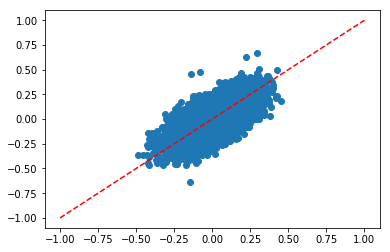

In [17]:
## 2018.11.07: for non sequencial data
def fit_additive(s,n,m):
    nloop = 10
    i1tab,i2tab = itab(n,m)

    nm = n*m
    nm1 = nm - m

    w_infer = np.zeros((nm,nm))

    for i in range(n):
        i1,i2 = i1tab[i],i2tab[i]

        # remove column i
        x = np.hstack([s[:,:i1],s[:,i2:]])
              
        x_av = np.mean(x,axis=0)
        dx = x - x_av
        c = np.cov(dx,rowvar=False,bias=True)
        c_inv = linalg.pinv(c,rcond=1e-15)

        #print(c_inv.shape)

        h = s[:,i1:i2].copy()
        for iloop in range(nloop):
            h_av = h.mean(axis=0)
            dh = h - h_av

            dhdx = dh[:,:,np.newaxis]*dx[:,np.newaxis,:]
            dhdx_av = dhdx.mean(axis=0)

            w = np.dot(dhdx_av,c_inv)
            
            #w = w - w.mean(axis=0) 

            h = np.dot(x,w.T)

            p = np.exp(h)
            p_sum = p.sum(axis=1)
            
            #p /= p_sum[:,np.newaxis]            
            for k in range(m):
                p[:,k] = p[:,k]/p_sum[:]
            
            h += s[:,i1:i2] - p
              
        w_infer[i1:i2,:i1] = w[:,:i1]
        w_infer[i1:i2,i2:] = w[:,i1:]
    
    return w_infer

w2 = fit_additive(s,n,m)

plt.plot([-1,1],[-1,1],'r--')
plt.scatter(w0,w2)

In [18]:
i1tab,i2tab = itab(n,m) 

nloop = 5
nm1 = nm - m

w_infer = np.zeros((nm,nm))
wini = np.random.normal(0.0,1./np.sqrt(nm),size=(nm,nm1))

for i in range(n):

    i1,i2 = i1tab[i],i2tab[i]

    x = np.hstack([s[:,:i1],s[:,i2:]])
    y = s.copy()

    # covariance[ia,ib]
    cab_inv = np.empty((m,m,nm1,nm1))
    eps = np.empty((m,m,l))
    for ia in range(m):
        for ib in range(m):
            if ib != ia:
                eps[ia,ib,:] = y[:,i1+ia] - y[:,i1+ib]

                which_ab = eps[ia,ib,:] !=0.                    
                xab = x[which_ab]          

                # ----------------------------
                xab_av = np.mean(xab,axis=0)
                dxab = xab - xab_av
                cab = np.cov(dxab,rowvar=False,bias=True)
                cab_inv[ia,ib,:,:] = linalg.pinv(cab,rcond=1e-15)


    w = wini[i1:i2,:].copy()            
    for iloop in range(nloop):
        h = np.dot(x,w.T)

        for ia in range(m):
            wa = np.zeros(nm1)
            for ib in range(m):
                if ib != ia:

                    which_ab = eps[ia,ib,:] !=0.

                    eps_ab = eps[ia,ib,which_ab]
                    xab = x[which_ab]

                    # ----------------------------
                    xab_av = np.mean(xab,axis=0)
                    dxab = xab - xab_av

                    h_ab = h[which_ab,ia] - h[which_ab,ib]                    
                    ha = np.divide(eps_ab*h_ab,np.tanh(h_ab/2.), out=np.zeros_like(h_ab), where=h_ab!=0)                        

                    dhdx = (ha - ha.mean())[:,np.newaxis]*dxab
                    dhdx_av = dhdx.mean(axis=0)

                    wab = cab_inv[ia,ib,:,:].dot(dhdx_av) # wa - wb

                    wa += wab
            w[ia,:] = wa/m

    w_infer[i1:i2,:i1] = w[:,:i1]
    w_infer[i1:i2,i2:] = w[:,i1:]
    
    #return w_infer

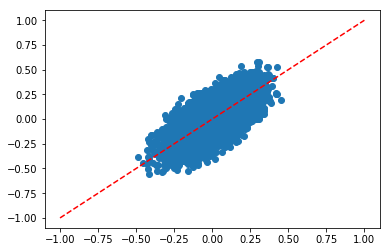

In [19]:
plt.plot([-1,1],[-1,1],'r--')
plt.scatter(w0,w_infer)
#plt.scatter(w0[0:3,3:],w[0:3,:])